# Demo SEA data calculations
This demonstrates the use of low-level routines to replicate signal analysis performed by SEA.

Each analysis product is returned as a `xarray.DataArray`. At the end, they are merged into a single `xarray.Dataset` containing all of the different data results along with their labels, coordinates, and metadata.

### Generate fake data

In [1]:
from edge_analysis import channel_waveform
from scipy import signal
from edge_analysis.io import simulated_awgn

duration = 4
sample_rate_Hz = 14e6
analysis_bandwidth_Hz = 10e6

raw_iq = simulated_awgn(duration, sample_rate_Hz)

### Analysis bandpass filter

In [2]:
%timeit -n1 -r1

filter_params = dict(
    passband_ripple_dB=0.1,
    stopband_attenuation_dB=70,
    transition_bandwidth_Hz=250e3,
)

sos = channel_waveform.generate_iir_lpf(
    cutoff_Hz=analysis_bandwidth_Hz / 2, sample_rate_Hz=sample_rate_Hz, **filter_params
).astype('float32')

iq = signal.sosfilt(sos, raw_iq)

In [3]:
%%timeit -n1 -r1
signal.sosfilt(sos, raw_iq)

947 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Channel power time-series

In [4]:
pvt = channel_waveform.power_time_series(
    iq,
    sample_rate_Hz=sample_rate_Hz,
    analysis_bandwidth_Hz=analysis_bandwidth_Hz,
    detector_period=10e-3,
    detectors=('rms', 'peak'),
)

In [5]:
%%timeit -n1 -r1

channel_waveform.power_time_series(
    iq,
    sample_rate_Hz=sample_rate_Hz,
    analysis_bandwidth_Hz=analysis_bandwidth_Hz,
    detector_period=10e-3,
    detectors=('rms', 'peak'),
)

403 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


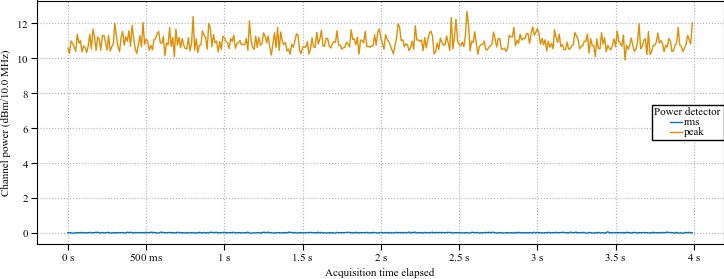

In [6]:
from iqwaveform import powtodB
from matplotlib import pyplot as plt
from edge_analysis import figures

plt.style.use('iqwaveform.ieee_double_column')

fig, ax = plt.subplots()

pvt.plot.line(x='time_elapsed', ax=ax)

figures.label_axis(ax.xaxis, pvt, 'time_elapsed')
figures.label_axis(ax.yaxis, pvt, tick_units=False)
figures.label_legend(ax, pvt, 'power_detector')

### Cyclic channel power

In [7]:
cyclic_power = channel_waveform.cyclic_channel_power(
    iq,
    sample_rate_Hz,
    analysis_bandwidth_Hz=analysis_bandwidth_Hz,
    cyclic_period=10e-3,
    detector_period=1e-3 / 14 / 4,
    detectors=('rms', 'peak'),
    cyclic_statistics=('min', 'mean', 'max'),
)

In [8]:
%%timeit -n1 -r1
cyclic_power = channel_waveform.cyclic_channel_power(
    iq,
    sample_rate_Hz,
    analysis_bandwidth_Hz=analysis_bandwidth_Hz,
    cyclic_period=10e-3,
    detector_period=1e-3 / 14 / 4,
    detectors=pvt.power_detector.values,
    cyclic_statistics=('min', 'mean', 'max'),
)

396 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


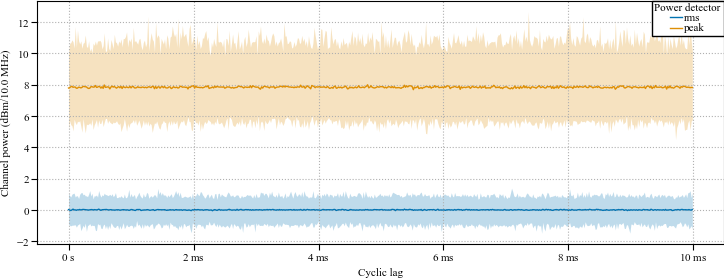

In [9]:
fig, ax = plt.subplots()

time = cyclic_power.cyclic_lag

for i, detector in enumerate(cyclic_power.power_detector.values):
    a = cyclic_power.sel(power_detector=detector)

    ax.plot(time, powtodB(a.sel(cyclic_statistic='mean')), color=f'C{i}')

for i, detector in enumerate(cyclic_power.power_detector.values):
    a = cyclic_power.sel(power_detector=detector)

    ax.fill_between(
        time,
        powtodB(a.sel(cyclic_statistic='min')),
        powtodB(a.sel(cyclic_statistic='max')),
        color=f'C{i}',
        alpha=0.25,
        lw=0,
        rasterized=True,
    )

figures.label_axis(ax.xaxis, cyclic_power, 'cyclic_lag')
figures.label_axis(ax.yaxis, cyclic_power, tick_units=False)
figures.label_legend(ax, cyclic_power, 'power_detector')

### Persistence Spectrum

In [10]:
frequency_resolution = 16e3
spectrum_quantiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 1]

spectrum = channel_waveform.persistence_spectrum(
    iq,
    sample_rate_Hz=sample_rate_Hz,
    window='flattop',
    resolution=frequency_resolution,
    quantiles=spectrum_quantiles,
)
spectrum

<xarray.DataArray 'persistence_spectrum' (baseband_frequency: 875,
                                          persistence_statistic: 9)>
array([[-107.68239771, -103.32656865,  -99.50744409, ...,  -91.29699758,
         -89.53153509,  -87.12430565],
       [-107.71090327, -103.38251882,  -99.50932435, ...,  -91.31012764,
         -89.49177112,  -87.02755135],
       [-107.79913195, -103.41979648,  -99.60030321, ...,  -91.33544004,
         -89.46208526,  -86.96456884],
       ...,
       [-107.77400986, -103.41518908,  -99.56840401, ...,  -91.36963887,
         -89.61109167,  -87.83134707],
       [-107.72627657, -103.37781017,  -99.53192136, ...,  -91.32283935,
         -89.54987243,  -87.97596146],
       [-107.67055833, -103.31178578,  -99.5299372 , ...,  -91.27206915,
         -89.50089869,  -87.61414697]])
Coordinates:
  * baseband_frequency     (baseband_frequency) float64 -6.992e+06 ... 6.992e+06
  * persistence_statistic  (persistence_statistic) <U5 '0.1' '0.25' ... '1'
Attributes:
    label:               Power spectral density
    units:               dBm/60.324 kHz
    window:              flattop
    resolution_Hz:       16000.0
    fractional_overlap:  0
    noise_bandwidth_Hz:  60323.943159094866
    fft_size:            875

In [11]:
%%timeit -n1 -r1
spectrum = channel_waveform.persistence_spectrum(
    iq,
    sample_rate_Hz=sample_rate_Hz,
    window='flattop',
    resolution=frequency_resolution,
    quantiles=spectrum_quantiles,
)

1.55 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


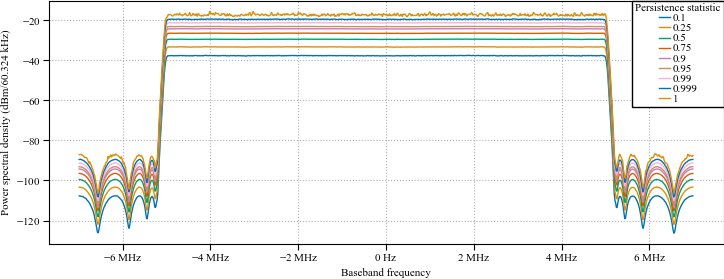

In [12]:
fig, ax = plt.subplots()

spectrum.plot.line(x='baseband_frequency', ax=ax)
figures.label_axis(ax.xaxis, spectrum, 'baseband_frequency')
figures.label_axis(ax.yaxis, spectrum, tick_units=False)
figures.label_legend(ax, spectrum, 'persistence_statistic')

### Amplitude Probability Distribution

In [13]:
apd_bins = dict(power_low=-40, power_high=15, power_count=55 * 4 + 1)

apd = channel_waveform.amplitude_probability_distribution(
    iq, analysis_bandwidth_Hz=analysis_bandwidth_Hz, **apd_bins
)

In [14]:
%%timeit -n1 -r1
apd = channel_waveform.amplitude_probability_distribution(
    iq, analysis_bandwidth_Hz=analysis_bandwidth_Hz, **apd_bins
)

2.56 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


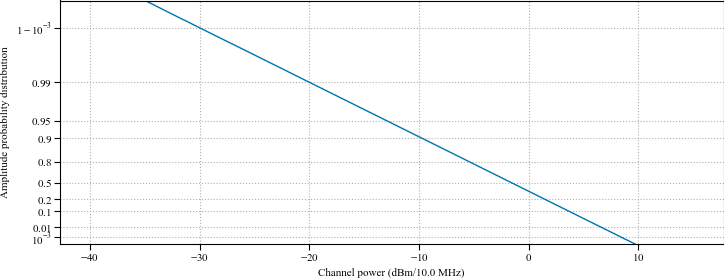

In [15]:
fig, ax = plt.subplots()
apd.plot(ax=ax)

ax.set_yscale('gamma-qq', k=1, major_ticks=16, db_ordinal=True)
figures.label_axis(ax.xaxis, apd, 'channel_power', tick_units=False)
figures.label_axis(ax.yaxis, apd)

### Merge into a single dataset

As one approach, we could merge the arrays into an `xarray.Dataset` as follows:

In [16]:
import xarray as xr

ds = xr.Dataset(
    {
        pvt.name: pvt,
        cyclic_power.name: cyclic_power,
        apd.name: apd,
        spectrum.name: spectrum,
    },
    attrs={
        'sample_rate_Hz': sample_rate_Hz,
        'analysis_bandwidth': analysis_bandwidth_Hz,
        'filter_parameters': filter_params,
    },
)

ds

<xarray.Dataset>
Dimensions:                             (power_detector: 2, time_elapsed: 400,
                                         cyclic_statistic: 3, cyclic_lag: 560,
                                         channel_power: 221,
                                         baseband_frequency: 875,
                                         persistence_statistic: 9)
Coordinates:
  * power_detector                      (power_detector) <U4 'rms' 'peak'
  * time_elapsed                        (time_elapsed) float64 0.0 0.01 ... 3.99
  * cyclic_statistic                    (cyclic_statistic) <U4 'min' ... 'max'
  * cyclic_lag                          (cyclic_lag) float64 0.0 ... 0.009982
  * channel_power                       (channel_power) float32 -40.0 ... 15.0
  * baseband_frequency                  (baseband_frequency) float64 -6.992e+...
  * persistence_statistic               (persistence_statistic) <U5 '0.1' ......
Data variables:
    power_time_series                   (power_detector, time_elapsed) float64 ...
    cyclic_channel_power                (power_detector, cyclic_statistic, cyclic_lag) float64 ...
    amplitude_probability_distribution  (channel_power) float64 0.9999 ... 0.0
    persistence_spectrum                (baseband_frequency, persistence_statistic) float64 ...
Attributes:
    sample_rate_Hz:      14000000.0
    analysis_bandwidth:  10000000.0
    filter_parameters:   {'passband_ripple_dB': 0.1, 'stopband_attenuation_dB...

As an alternative approach, we can also specify an analysis run through a dictionary (for example, in a json file), and run everything together as a batch:

In [17]:
from edge_analysis import channel_waveform

analysis_spec = {
    'power_time_series': {'detector_period': 10e-3, 'detectors': ('rms', 'peak')},
    'cyclic_channel_power': {
        'cyclic_period': 10e-3,
        'detector_period': 1e-3 / 14 / 4,
        'detectors': ('rms', 'peak'),
        'cyclic_statistics': ('min', 'mean', 'max'),
    },
    'amplitude_probability_distribution': {
        'power_low': -40,
        'power_high': 15,
        'power_count': 221,  # 0.25 dB resolution
    },
    'persistence_spectrum': {
        'window': 'flattop',
        'resolution': 16e3,
        'quantiles': [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 1],
    },
}

filter_params = dict(
    passband_ripple_dB=0.1,
    stopband_attenuation_dB=70,
    transition_bandwidth_Hz=250e3,
)

channel_waveform.from_spec(
    raw_iq,
    sample_rate_Hz,
    analysis_bandwidth_Hz=analysis_bandwidth_Hz,
    filter_spec=filter_params,
    analysis_spec=analysis_spec,
)

<xarray.Dataset>
Dimensions:                             (power_detector: 2, time_elapsed: 400,
                                         cyclic_statistic: 3, cyclic_lag: 560,
                                         channel_power: 221,
                                         baseband_frequency: 875,
                                         persistence_statistic: 9)
Coordinates:
  * power_detector                      (power_detector) <U4 'rms' 'peak'
  * time_elapsed                        (time_elapsed) float64 0.0 0.01 ... 3.99
  * cyclic_statistic                    (cyclic_statistic) <U4 'min' ... 'max'
  * cyclic_lag                          (cyclic_lag) float64 0.0 ... 0.009982
  * channel_power                       (channel_power) float32 -40.0 ... 15.0
  * baseband_frequency                  (baseband_frequency) float64 -6.992e+...
  * persistence_statistic               (persistence_statistic) <U5 '0.1' ......
Data variables:
    power_time_series                   (power_detector, time_elapsed) float64 ...
    cyclic_channel_power                (power_detector, cyclic_statistic, cyclic_lag) float64 ...
    amplitude_probability_distribution  (channel_power) float64 0.9999 ... 0.0
    persistence_spectrum                (baseband_frequency, persistence_statistic) float64 ...
Attributes:
    sample_rate_Hz:         14000000.0
    analysis_bandwidth_Hz:  10000000.0
    filter_specification:   {'passband_ripple_dB': 0.1, 'stopband_attenuation...